# Discovering Spatio-Temporal Crime Patterns Using Unsupervised Learning


*by Justin Kim and Srishti Rajpurohit*

**Dataset:** [Seattle Police Department Crime Incident Data (2008–Present)](https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5/about_data)
(Dataset downloaded on February 10, 2026 at 4:05 PM)

This notebook applies unsupervised learning methods, specifically clustering, to analyze spatial and temporal patterns in Seattle crime incident data. The analysis includes preprocessing, exploratory data analysis, and feature engineering to prepare the dataset for pattern discovery.


## 0. Setup

In [37]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Overview

### 1.1 Load Data

In [3]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('data/SPD_Crime_Data__2008-Present_20260210.csv')

### 1.2 Initial Inspection

In [4]:
# Display the first few rows of the DataFrame to verify it loaded correctly
df.head()

,Report Number,Report DateTime,Offense ID,Offense Date,NIBRS Group AB,NIBRS Crime Against Category,Offense Sub Category,Shooting Type Group,Block Address,Latitude,Longitude,Beat,Precinct,Sector,Neighborhood,Reporting Area,Offense Category,NIBRS Offense Code Description,NIBRS_offense_code
0,2015-190826,2015 Jun 08 09:39:00 AM,7655587915,2015 May 24 02:00:00 PM,A,PROPERTY,LARCENY-THEFT,-,26XX BLOCK OF W MARINA PL,47.63103937,-122.391970808268,Q1,West,Q,-,7089,PROPERTY CRIME,All Other Larceny,23H
1,2008-479747,2008 Dec 28 10:14:00 PM,7639775836,2008 Dec 28 10:14:00 PM,A,PROPERTY,LARCENY-THEFT,-,-,-1.0,-1.0,D2,West,D,-,3700,PROPERTY CRIME,Theft From Motor Vehicle,23F
2,2014-158003,2014 May 20 05:42:00 PM,7668842409,2014 May 20 05:42:00 PM,A,PROPERTY,LARCENY-THEFT,-,-,-1.0,-1.0,F3,Southwest,F,-,4197,PROPERTY CRIME,All Other Larceny,23H
3,2012-380870,2012 Nov 06 09:40:00 AM,7649760707,2012 Nov 04 08:00:00 PM,A,PROPERTY,BURGLARY,-,30XX BLOCK OF 29TH AVE W,47.64773751,-122.394242455682,Q1,West,Q,-,7024,PROPERTY CRIME,Burglary/Breaking & Entering,220
4,2014-041879,2014 Feb 07 10:47:00 PM,7628705100,2014 Feb 07 09:00:00 PM,A,PROPERTY,LARCENY-THEFT,-,7XX BLOCK OF S DEARBORN ST,47.59583224,-122.323111156883,K3,West,K,-,1502,PROPERTY CRIME,Theft From Motor Vehicle,23F


In [5]:
# Display the column names to understand the structure of the dataset
df.columns

Index(['Report Number', 'Report DateTime', 'Offense ID', 'Offense Date',
       'NIBRS Group AB', 'NIBRS Crime Against Category',
       'Offense Sub Category', 'Shooting Type Group', 'Block Address',
       'Latitude', 'Longitude', 'Beat', 'Precinct', 'Sector', 'Neighborhood',
       'Reporting Area', 'Offense Category', 'NIBRS Offense Code Description',
       'NIBRS_offense_code'],
      dtype='object')

In [6]:
# Display shape of the DataFrame to understand how many rows and columns it contains
df.shape

(1514383, 19)

In [7]:
# Display summary statistics of the DataFrame to understand the distribution of numerical columns
df.describe()

,Offense ID
count,1.514383e+06
mean,1.903475e+10
std,1.899956e+10
min,7.624429e+09
25%,7.659382e+09
50%,7.689669e+09
75%,2.640175e+10
max,6.849260e+10


In [8]:
# Display information about the DataFrame to understand data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514383 entries, 0 to 1514382
Data columns (total 19 columns):
 #   Column                          Non-Null Count    Dtype 
---  ------                          --------------    ----- 
 0   Report Number                   1514383 non-null  object
 1   Report DateTime                 1514383 non-null  object
 2   Offense ID                      1514383 non-null  int64 
 3   Offense Date                    1514383 non-null  object
 4   NIBRS Group AB                  1514383 non-null  object
 5   NIBRS Crime Against Category    1514383 non-null  object
 6   Offense Sub Category            1514383 non-null  object
 7   Shooting Type Group             1514383 non-null  object
 8   Block Address                   1514383 non-null  object
 9   Latitude                        1514383 non-null  object
 10  Longitude                       1514383 non-null  object
 11  Beat                            1514383 non-null  object
 12  Precinct      

**1.2.1 Structural Summary of the Dataset**

The dataset contains 1,514,383 crime incident records and 19 variables, representing reported crime events in Seattle over multiple years. With a memory footprint of approximately 219 MB, the dataset is sufficiently large to support meaningful exploratory and clustering analysis.

**Data Composition**

Each row corresponds to a single reported crime incident. The dataset can be grouped into the following structural components:

- **Identifier variables:** `Report Number` and `Offense ID` function as unique identifiers and do not provide analytical value for modeling.

- **Temporal variables:** `Report DateTime` and `Offense Date` capture when the incident occurred and was reported. Both are currently stored as object types and must be converted to datetime format for temporal feature extraction (e.g., `year`, `month`, `hour`, `day_of_week`).

- **Spatial variables:** `Latitude`, `Longitude`, `Precinct`, `Sector`, `Beat`, `Neighborhood`, and `Reporting Area` provide geographic information. `Latitude` and `Longitude` are stored as object types and contain placeholder values such as `-1.0`, indicating invalid or missing coordinates that must be addressed prior to spatial analysis.

- **Crime classification variables:** `Offense Category`, `Offense Sub Category`, `NIBRS Crime Against Category`, `NIBRS Offense Code Description`, and `NIBRS_offense_code` describe the nature of the offense at varying levels of granularity, enabling hierarchical analysis of crime types.

**Data Type Characteristics**

The dataset is predominantly categorical, with 18 object-type variables and only one numeric identifier column (`Offense ID`). This structure implies that substantial feature transformation and encoding will be required prior to applying clustering algorithms.

**Data Quality Considerations**

Although no explicit null values are present, placeholder values such as -1.0 in geographic coordinates and "-" in categorical fields indicate implicit missing data. These values must be identified and handled during preprocessing to ensure accurate analysis.

## 2. Data Preprocessing

### 2.1 Missing & Invalid Values

**2.1.1 Implicit Missing Values – Geographic Coordinates**


In [9]:
# Confirm the percentage of missing values in each column (should be 0 based on the info() output)
(df.isna().sum() / len(df)) * 100

Report Number                     0.0
Report DateTime                   0.0
Offense ID                        0.0
Offense Date                      0.0
NIBRS Group AB                    0.0
NIBRS Crime Against Category      0.0
Offense Sub Category              0.0
Shooting Type Group               0.0
Block Address                     0.0
Latitude                          0.0
Longitude                         0.0
Beat                              0.0
Precinct                          0.0
Sector                            0.0
Neighborhood                      0.0
Reporting Area                    0.0
Offense Category                  0.0
NIBRS Offense Code Description    0.0
NIBRS_offense_code                0.0
dtype: float64

In [10]:
# Convert 'Latitude' and 'Longitude' columns to numeric, coercing errors to NaN
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Check for invalid coordinates (Latitude or Longitude equal to -1.0)
invalid_coords = ((df['Latitude'] == -1.0) | (df['Longitude'] == -1.0))
invalid_coords.sum()


np.int64(171772)

In [11]:
# Calculate the percentage of invalid coordinates in the dataset
invalid_coords.sum() / len(df) * 100

np.float64(11.34270524695536)

Although no explicit null values were detected, inspection of the geographic fields revealed placeholder values of -1.0 in the Latitude and Longitude columns. These values represent invalid or missing spatial information.

After converting both columns to numeric format, 172,314 records were identified as containing invalid coordinates, representing approximately 11.34% of the dataset.

Because spatial clustering requires valid geographic information, these records cannot meaningfully contribute to spatial pattern discovery.

In [12]:
# Drop records lacking valid coordinates
df = df[~invalid_coords].copy()

# Check shape of the DataFrame after dropping invalid coordinates
df.shape

(1342611, 19)

To ensure meaningful spatial analysis, all records with invalid geographic coordinates were removed from the dataset.

This preprocessing step reduces noise and prevents distortion in subsequent clustering analysis, as incidents lacking valid latitude and longitude values cannot be assigned to spatial clusters.

The dataset now consists exclusively of incidents with valid spatial information (1,342,611 records).

**2.1.2 Geographic Boundary Validation**

In [13]:
# Calculate the percentage of records with Latitude outside the expected range for Seattle (47 to 48 degrees)
invalid_geo = ((df['Latitude'] < 47) | (df['Latitude'] > 48)) | ((df['Longitude'] < -123) | (df['Longitude'] > -122))
invalid_geo.sum() / len(df) * 100

np.float64(0.04059254691046029)

In [14]:
df = df[~invalid_geo].copy()

In addition to placeholder values (-1.0), a small number of records contained geographic coordinates outside realistic Seattle bounds. A bounding box was defined based on Seattle’s approximate latitude and longitude range.

A total of 542 records (approximately 0.04%) were identified as having coordinates outside these bounds and were removed. These values likely represent data entry or geocoding errors.

Removing these records ensures that subsequent spatial analysis is restricted to valid geographic locations within Seattle.

**2.1.3 Implicit Missing Values - Categorical Geographic Fields**

In [ ]:
# Check for invalid Categorical Geographic Data (e.g., "Neighborhood", "Beat", "Precinct", "Sector") represented as "-"
geo_cat_cols = ["Neighborhood", "Beat", "Precinct", "Sector"]

dash_counts = {col: (df[col] == "-").sum() for col in geo_cat_cols}
dash_pct = {col: (df[col] == "-").mean() * 100 for col in geo_cat_cols}

summary = pd.DataFrame({
    "dash_count": [dash_counts[c] for c in geo_cat_cols],
    "dash_pct": [dash_pct[c] for c in geo_cat_cols],
}, index=geo_cat_cols)

summary

,dash_count,dash_pct
Neighborhood,575002,42.844540
Beat,2840,0.211614
Precinct,2329,0.173538
Sector,2834,0.211167


Inspection of categorical geographic fields revealed the presence of placeholder values ("-") representing implicit missing data. 

Approximately 42.8% of records lack an assigned `Neighborhood`, while missing values in `Beat`, `Precinct`, and `Sector` account for less than 1% of records. These placeholder values must be addressed to ensure accurate aggregation and grouping during exploratory analysis.

In [30]:
# Replace "-" with NaN in the geographic categorical columns
df[geo_cat_cols] = df[geo_cat_cols].replace("-", np.nan)

# Verify that the replacement was successful by checking the counts of "-" again
dash_counts_after = {col: (df[col] == "-").sum() for col in geo_cat_cols}
dash_counts_after

{'Neighborhood': np.int64(0),
 'Beat': np.int64(0),
 'Precinct': np.int64(0),
 'Sector': np.int64(0)}

The placeholder values ("-") were replaced with NaN to ensure proper handling of missing data within pandas operations. 

All affected columns were verified to confirm successful replacement. Records were retained because geographic coordinates (Latitude and Longitude) remain available for spatial analysis even when categorical geographic labels are missing.

### 2.2 Type Conversion

In [15]:
# Define the expected date format for 'Report DateTime' and 'Offense Date' columns
fmt = "%Y %b %d %I:%M:%S %p"   # e.g., 2015 Jun 08 09:39:00 AM

# Convert 'Report DateTime' and 'Offense Date' columns to datetime, coercing errors to NaT
df["Report DateTime"] = pd.to_datetime(df["Report DateTime"], format=fmt, errors="coerce")
df["Offense Date"] = pd.to_datetime(df["Offense Date"], format=fmt, errors="coerce")

# Check for any remaining missing values in the 'Report DateTime' and 'Offense Date' columns after conversion
df[["Report DateTime", "Offense Date"]].isna().sum()

Report DateTime    0
Offense Date       0
dtype: int64

The Report DateTime and Offense Date columns were originally stored as string (object) types. These variables were converted to datetime format using an explicit format specification to ensure accurate temporal parsing and avoid inference errors. No malformed timestamps were detected during conversion.

### 2.3 Cleaning & Filtering

**2.3.1 Temporal Boundary Enforcement**

In [16]:
df["Offense Date"].dt.year.describe()

count    1.342066e+06
mean     2.017126e+03
std      5.157364e+00
min      1.900000e+03
25%      2.013000e+03
50%      2.018000e+03
75%      2.022000e+03
max      2.026000e+03
Name: Offense Date, dtype: float64

In [17]:
# Count the number of records with 'Offense Date' before 2008
(df["Offense Date"].dt.year < 2008).sum()

np.int64(2205)

Although datetime conversion was successful, inspection of the offense year distribution revealed the presence of records prior to the documented dataset start year (2008). A total of 2,205 records were identified with offense dates before 2008. To ensure temporal consistency with the dataset scope, these records were removed.

**2.3.2 Identifier Column Removal**

In [18]:
df = df.drop(columns=["Report Number", "Offense ID"])

Identifier columns were removed as they do not contain analytical signal and are unsuitable for modeling or clustering purposes.


**2.3.3 Removal of High-Granularity Address Field**

In [19]:
df["Block Address"].nunique()

36091

In [20]:
df = df.drop(columns=["Block Address"])

The `Block Address` column provides street-level textual descriptions of incident locations and contains approximately 3,601 unique values. While this level of detail may be useful in street-specific investigations, it introduces unnecessary granularity for the purposes of clustering analysis.

The dataset already includes structured geographic variables such as `Neighborhood`, `Precinct`, `Sector`, and `Beat`, which provide meaningful categorical representations of location. In addition, precise spatial coordinates (`Latitude` and `Longitude`) are available for continuous spatial analysis.

Because the block-level address information is both redundant and difficult to encode meaningfully for distance-based clustering algorithms, it was removed to reduce dimensionality and maintain a clean feature space.

## 3. Exploratory Data Analysis

### 3.1 Temporal Patterns

### 3.2 Spatial Patterns

**3.2.1 Crime Count by Neighborhood**

In [35]:
# Drop missing values in the 'Neighborhood' column
neighborhood_counts = (
    df["Neighborhood"]
    .dropna()
    .value_counts()
)

neighborhood_counts.head(15)

Neighborhood
DOWNTOWN COMMERCIAL                 55019
CAPITOL HILL                        51048
NORTHGATE                           42955
QUEEN ANNE                          39937
SLU/CASCADE                         35126
UNIVERSITY                          31168
ROOSEVELT/RAVENNA                   28459
BALLARD SOUTH                       27704
FIRST HILL                          26875
CHINATOWN/INTERNATIONAL DISTRICT    23945
LAKECITY                            20612
CENTRAL AREA/SQUIRE PARK            19957
BELLTOWN                            19242
SANDPOINT                           16793
GREENWOOD                           15807
Name: count, dtype: int64

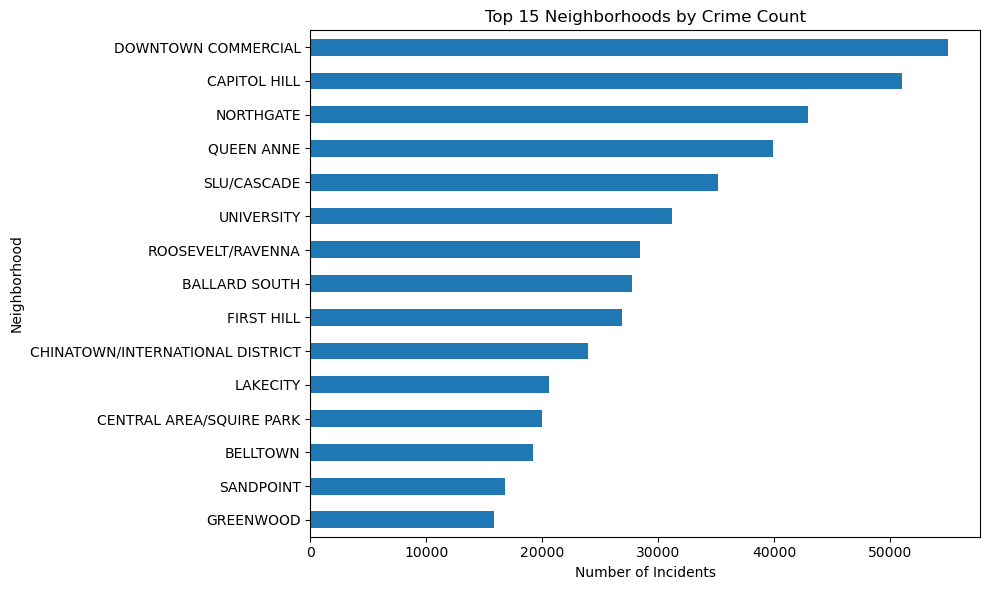

In [38]:
top_15 = neighborhood_counts.head(15)

plt.figure(figsize=(10, 6))
top_15.sort_values().plot(kind="barh")
plt.xlabel("Number of Incidents")
plt.ylabel("Neighborhood")
plt.title("Top 15 Neighborhoods by Crime Count")
plt.tight_layout()
plt.show()

Crime incidents are highly concentrated in central and mixed-use neighborhoods. Downtown Commercial exhibits the highest number of reported incidents, followed closely by Capitol Hill and Northgate. 

This pattern suggests spatial clustering in high-density commercial and entertainment areas, where population flow and activity levels are elevated. Peripheral and predominantly residential neighborhoods show comparatively lower incident frequencies.

**3.2.2 Crime Count by Precinct**

In [22]:
df["Precinct"].value_counts()

Precinct
North        408372
West         383614
East         225733
South        191445
Southwest    127439
OOJ            3134
-              2329
Name: count, dtype: int64

**3.1.3 Spatial Density Visualization**

### 3.3 Crime Category Analysis

## 4. Feature Engineering

### 4.1 Temporal Features

### 4.2 Spatial Features

### 4.3 Encoding

### 4.4 Scaling